## Stormer-Verlet loop for the Von Karman plate

This is a notebook that shows how to solve the Von Karman plate equation using the Stormer-Verlet method using Jax.It achieves real-time performance (at 44100 Hz) for 100 modes.

In [1]:
import einops
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat

# Using double precision will make the computation around 2.5x slower but more accurate
# jax.config.update("jax_enable_x64", True)

In [2]:
params = loadmat("../matlab/param/Test_NL_Fullclamp_1.mat")

In [3]:
print(params.keys())

dict_keys(['__header__', '__version__', '__globals__', 'BCsPhi', 'BCsPsi', 'E', 'Hv', 'Lx', 'Ly', 'Lz', 'Nmodes', 'Nx', 'Ny', 'Om', 'Om2', 'Phi', 'Psi', 'X', 'Y', 'h', 'nu', 'rho', 'zetafourth'])


In [4]:
# fmt: off
n_modes = params["Nmodes"].reshape(-1)[0]
Nx = params["Nx"].reshape(-1)[0]                # Number of grid points in the x direction
Ny = params["Ny"].reshape(-1)[0]                # Number of grid points in the y direction
zetafourth = params["zetafourth"].reshape(-1)   # Eigenvalues of the stress (n_modes, 1)
Hv = params["Hv"]                               # Coupling coefficients (n_modes, n_modes, n_modes)
E = params["E"].reshape(-1)[0]                  # young modulus scalar
Lz = params["Lz"].reshape(-1)[0]                 # thickness scalar
rho = params["rho"].reshape(-1)[0]              # density scalar
nu = params["nu"].reshape(-1)[0]                # Poisson ratio scalar
Omega = params["Om"].reshape(-1)
eta = np.zeros((n_modes,))                      # Modal stress vector at n (n_modes, 1)
nlsv = np.zeros((n_modes,))                     # Nonlinear term of Stormer Verlet

# declared parameters
sr = 44100                                      # sample rate
os = 1                                          # oversampling factor
T = 1                                           # duration
xi = 0.005                                      # Damping

# derived parameters
D = E * Lz**3 / 12 / (1 - nu**2)
k = 1 / sr / os                                 # time step
Ts = int(T // k)                                # Number of time grid points
# fmt: on

print(f"Number of modes: {n_modes}")
print(f"Number of grid points in the x direction: {Nx}")
print(f"Number of grid points in the y direction: {Ny}")
print(f"Number of time grid points: {Ts}")

print("E: ", E)
print("h: ", Lz)
print("rho: ", rho)
print("nu: ", nu)

print(f"D: {D}")
print(f"Time step: {k}")
print(f"Duration: {T}")
print(f"Sample rate: {sr}")

Number of modes: 100
Number of grid points in the x direction: 630
Number of grid points in the y direction: 1260
Number of time grid points: 44099
E:  200000000000.0
h:  0.001
rho:  8000
nu:  0.3
D: 18.315018315018317
Time step: 2.2675736961451248e-05
Duration: 1
Sample rate: 44100


In [5]:
A_inv = 1 / (0.5 * k * xi * Omega + np.ones(n_modes))
B = 2 * np.ones(n_modes) - k**2 * Omega**2  # Stiffness term (n_modes, n_modes)
C = 0.5 * k * xi * Omega - np.ones(n_modes)  # Damping term in the Stormer-Verlet scheme

### Force

modal_excitation:  [  4.26102448  16.95774804  37.83287087  66.46335748 102.26900949
 144.52422343 192.37269507 244.84477254 300.87710633 359.33419814]
modal_excitation:  [  6.89917805  27.45689999  61.25656246 107.61321346 165.58743293
 234.00437017 311.47755221 396.4369808  487.1609485  581.81092916]


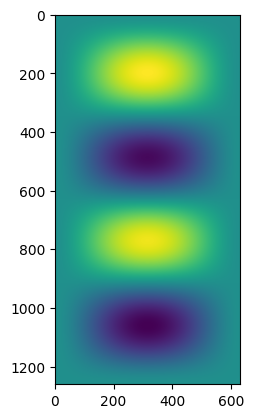

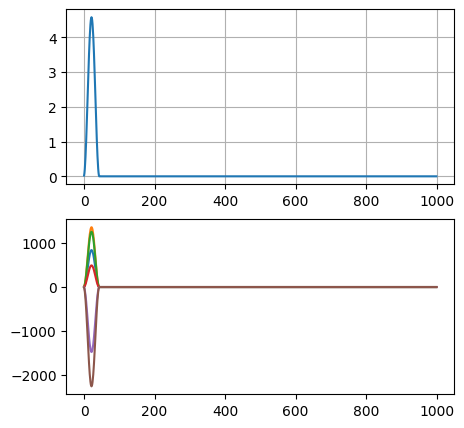

In [6]:
Phi = params["Phi"]

c0 = D / (rho * Lz)  # wave speed
T0 = 0.0005  # time duration of the excitation
Thw = 0.0005  # time duration of the hammer impact

fext = np.zeros((Ts,))
for n in range(1, Ts + 1):
    if np.abs(n * k - T0) < Thw:
        fext[n - 1] = 1 * c0 * (1 + np.cos(np.pi * (n * k - T0) / Thw))

# important to unravel using column order!
# Phi_reshaped has shape (Ny+1, Nx+1, n_modes)
Phi_reshaped = np.reshape(Phi, shape=(Ny + 1, Nx + 1, -1), order="F")
tmp = Phi_reshaped[:, :, 0]
val = tmp[tmp.shape[0] // 4 - 1, tmp.shape[1] // 4 - 1]

modal_excitation = np.zeros((n_modes, Ts))
for m in range(n_modes):
    # modal_shape is the eigenfunction of the plate for mode m
    modal_shape = Phi_reshaped[..., m]
    modal_excitation[m] = (
        200
        * fext
        * modal_shape[modal_shape.shape[0] // 4 - 1, modal_shape.shape[1] // 4 - 1]
    )

fig, ax = plt.subplots()
ax.imshow(Phi_reshaped[:, :, 3])

fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(fext[:1000])
ax[0].grid()
_ = ax[1].plot(modal_excitation[:6, :1000].T)

print("modal_excitation: ", modal_excitation[0, :10])
print("modal_excitation: ", modal_excitation[1, :10])

## Main Loop

In [7]:
zetafourth = jnp.array(zetafourth)
Hv = jnp.array(Hv)
B = jnp.array(B)
C = jnp.array(C)
A_inv = jnp.array(A_inv)
modal_excitation = jnp.array(modal_excitation)

print("zetafourth: ", zetafourth.dtype)

zetafourth:  float32


In [8]:
@jax.jit
def solve_sverlet_jax_scan(
    E: float,
    Lz: float,
    k: float,
    zetafourth: jnp.ndarray,
    Hv: jnp.ndarray,
    B: jnp.ndarray,
    C: jnp.ndarray,
    A_inv: jnp.ndarray,
    modal_excitation: jnp.ndarray,
):
    q = jnp.zeros((n_modes,))  # Modal displacement vector at n (n_modes, 1)
    q_prev = jnp.zeros((n_modes,))  # Modal displacement vector at n-1

    # store Hva to make it a bit faster
    Hva = Hv / (2.0 * zetafourth)
    factor = -(E * Lz)
    k2 = k**2
    factor2 = k2 / (rho * Lz)

    def advance_state(
        state: jnp.ndarray,  # inital state
        x: jnp.ndarray,  # input
    ) -> tuple[jnp.ndarray, jnp.ndarray]:  # carry, output
        # unpack state
        q_prev, q = state

        nlsv = factor * einops.einsum(
            Hva,
            Hv,
            q,
            q,
            q,
            "m i j, k l j, i, k, l -> m",
        )

        # compute the next state
        q_next = A_inv * (B * q + C * q_prev + factor2 * nlsv + k2 * x)

        # return the next state and the output
        return (q, q_next), q_next

    state, final = jax.lax.scan(
        advance_state,
        (q_prev, q),
        modal_excitation,  # (T, n_modes)
        unroll=8,
    )
    return state, final

In [9]:
modal_excitation_transposed = einops.rearrange(
    modal_excitation,
    "n_modes timesteps -> timesteps n_modes",
)[1:]

In [14]:
print("Timing the compilation time")
%time solve_sverlet_jax_scan(E, Lz, k, zetafourth, Hv, B, C, A_inv, modal_excitation_transposed)[1].block_until_ready()

print("Timing the execution time")
%timeit -r 5 -n 1 solve_sverlet_jax_scan(E, Lz, k, zetafourth, Hv, B, C, A_inv, modal_excitation_transposed)[1].block_until_ready()

Timing the compilation time
CPU times: user 231 ms, sys: 576 ms, total: 807 ms
Wall time: 984 ms
Timing the execution time
977 ms ± 797 μs per loop (mean ± std. dev. of 5 runs, 1 loop each)


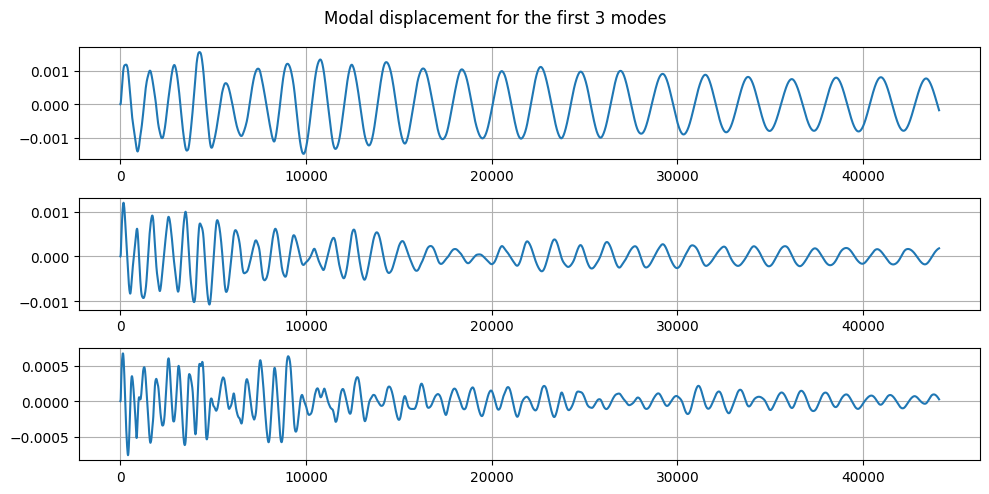

In [15]:
_, final_sv_jax_scan = solve_sverlet_jax_scan(
    E,
    Lz,
    k,
    zetafourth,
    Hv,
    B,
    C,
    A_inv,
    modal_excitation_transposed,
)

# we need to take the 2nd timestep onwards to compare
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].plot(final_sv_jax_scan[:-1, 0])
ax[1].plot(final_sv_jax_scan[:-1, 1])
ax[2].plot(final_sv_jax_scan[:-1, 2])
[ax_.grid() for ax_ in ax]
fig.suptitle("Modal displacement for the first 3 modes")
fig.tight_layout()
plt.show()

### Convert from modal to physical space

In [16]:
Phi_reshaped = jnp.array(Phi_reshaped)  # (Ny+1, Nx+1, n_modes)
modal_sol = final_sv_jax_scan  # (Ts, n_modes)

# Extract the modal coefficients for the specific point (x_idx, y_idx)
x_idx = Phi_reshaped.shape[0] // 2
y_idx = Phi_reshaped.shape[1] // 2
phi_point = Phi_reshaped[x_idx, y_idx, :]  # Shape: (n_modes,)

# sol at point
sol = einops.einsum(modal_sol, phi_point, "timesteps modes, modes -> timesteps")

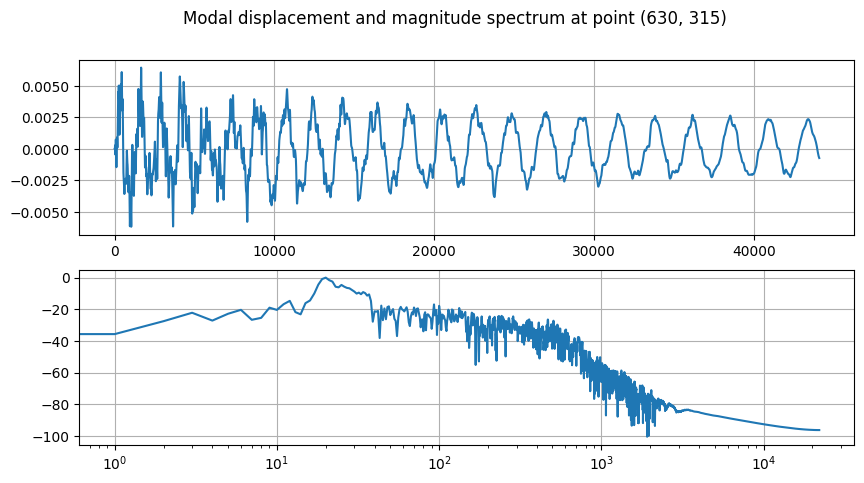

In [17]:
from IPython.display import Audio

# sound at the middle
freqs = np.fft.rfftfreq(len(sol), d=1 / sr)
sfft = 20 * np.log10(np.abs(np.fft.rfft(sol[:])))
sfft = sfft - np.max(sfft)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(sol)
ax[1].semilogx(freqs, sfft)
[ax_.grid() for ax_ in ax]
fig.suptitle(f"Modal displacement and magnitude spectrum at point ({x_idx}, {y_idx})")

display(Audio(sol, rate=sr))